# Approximating Pulses

## Basic Setup

In [77]:
%matplotlib inline
import csv
import numpy as np
import matplotlib.pyplot as plt

## Loading data files

Coefficients and Pulses from the first frame of Akiyo

In [79]:
coeffs = np.genfromtxt('data/coeffs4x4.csv', delimiter=',')
coeffs = coeffs[:,0:15]
pulses = np.genfromtxt('data/pulses4x4.csv', delimiter=',')
pulses = pulses[:,0:15]
ks = np.genfromtxt('data/k4x4.csv', delimiter=',')

Index of the lines sorted by K (needed to display the error by increasing K)

In [71]:
ind = np.argsort(ks)

Sanity check that the pulses match with k

In [32]:
numLines = len(ks)

for i in range(0, numLines):
    assert(ks[i] == sum(abs(pulses[i,:])))

## Gain and Shape

In [3]:
def gain(v):
    return np.sqrt(np.dot(v,v))

def shape(v):
    return np.true_divide(v, gain(v))

## Approximating Pulses
Let's not round for now so we can conserve precision

In [43]:
approxPulses = np.zeros(shape=pulses.shape)
for i in range(0,len(pulses)):
    s = shape(coeffs[i,:])
    approxPulses[i] = np.true_divide(s,sum(np.abs(s)))*ks[i]

for i in range(0, numLines):
    assert(ks[i] - sum(abs(approxPulses[i,:])) < 0.0001)    

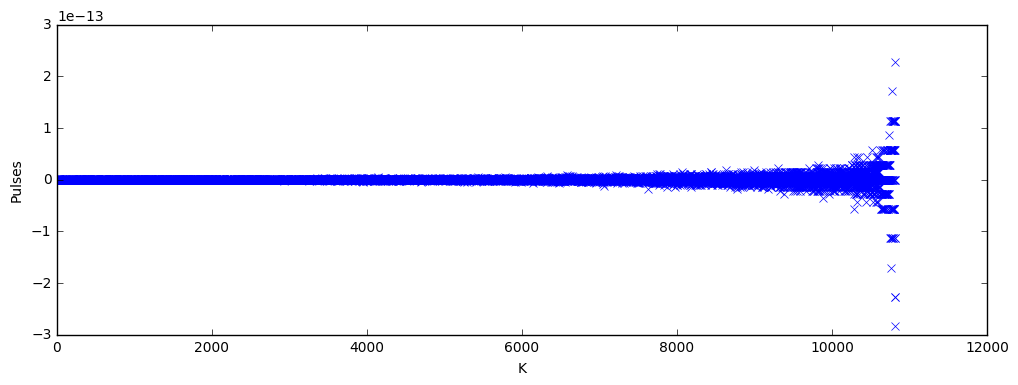

In [74]:
plt.figure(figsize=(12,4))
error = np.abs(approxPulses[:]).sum(axis=1) - np.abs(pulses[:]).sum(axis=1)

f = plt.plot(error[ind], marker="x", linestyle="none")
f = plt.xlabel('K')
f = plt.ylabel('Pulses')

## Error on KLeft

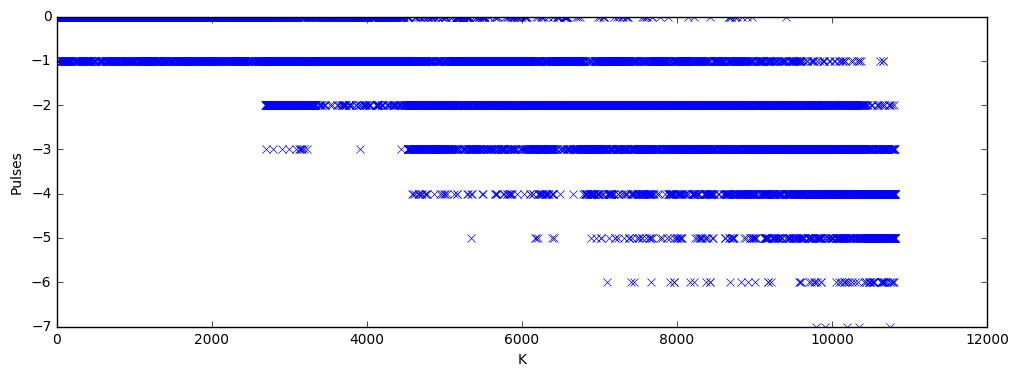

In [76]:
plt.figure(figsize=(12,4))
KLeftErr = np.round(np.abs(approxPulses[:,0:7]).sum(axis=1)) - np.abs(pulses[:,0:7]).sum(axis=1)

f = plt.plot(KLeftErr[ind], marker="x", linestyle="none")
f = plt.xlabel('K')
f = plt.ylabel('Pulses')